In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

In [2]:
class CelebADatasetPreprocessing(Dataset):
    def __init__(self, img_dir, attr_path, transform=None):
        self.img_dir = img_dir
        self.attr_path = attr_path
        self.transform = transform
        self.attr_list = []
        self.attr_list = self.get_attributes()
        self.task = []
        self.task = self.task_2()
        
    def __len__(self):
        return len(self.attr_list)

    def __getitem__(self, idx):
        img_path = f'{self.img_dir}/{idx+1:06}.jpg' #inputs the first image path
        image = Image.open(img_path).convert('RGB') #opens the first image and stores it as RGB
        #print(image.size)
        attribute_vectors = torch.tensor(self.attr_list[idx], dtype=torch.float32)
        task2_changed_attributes = torch.tensor(self.task[idx], dtype=torch.float32)
        #converts the attribute vector to a tensor
        if self.transform:
             image = self.transform(image) #transforms the image based on the defined transformation
        fc_layer = torch.nn.Linear(40,64*64)(attribute_vectors) 
        #passing the tensor attributes through a fully connected layer:o/p dimension is (64*64)
        reshaped_attr = fc_layer.view(1,64,64) 
        #reshaped again to dimensions(1,64,64)
        attribute_channel = torch.zeros_like(image[0])+reshaped_attr
        image = torch.cat([image,attribute_channel],dim=0)
        #image(3,64,64) and the attribute (1,64,64) concatenated and gives output ->(4,64,64)
        return image, attribute_vectors, task2_changed_attributes #image(4,64,64) and attributevector tensor(40)
    
    def get_attributes(self):
        attr_list = []
        with open(self.attr_path, 'r') as f: #opens the attribute txt file
            lines = f.readlines() #stores each line as a list
            for i, line in enumerate(lines): #[(0,'element1 from lines list'),(1,'element1 from lines list'),....]
                if i < 2:
                    continue  #removes the string elements[(2,'img1 -1 1...40...')]
                attr = line.split()[1:] #splits to 'img1 -1 1...40...' and ignores img1 and stores from -1 1...40... as string
                attr = [int(a) for a in attr] #converts string to integer and stores as list -> [...40..]
                attr_list.append(attr) #appends each list 
        return attr_list #returns shape [[...40..],[...40...],[...40...],...2Lakhs]
    
    def task_2(self):
        attr_list = []
        with open(self.attr_path, 'r') as f: #opens the attribute txt file
            lines = f.readlines() #stores each line as a list
            for i, line in enumerate(lines): #[(0,'element1 from lines list'),(1,'element1 from lines list'),....]
                if i < 2:
                    continue  #removes the string elements[(2,'img1 -1 1...40...')]
                attr = line.split()[1:] #splits to 'img1 -1 1...40...' and ignores img1 and stores from -1 1...40... as string
                attr = [int(a) for a in attr] #converts string to integer and stores as list -> [...40..]
                if attr[15] ==-1:   #by changing values of 31,22,15 we get different outputs
                    attr[15]=1
                # else:
                #     attr[22]=1
                attr_list.append(attr) #appends each list 
        return attr_list #returns shape [[...40..],[...40...],[...40...],...2Lakhs]
    

In [3]:
# Set up transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [4]:
dataset = CelebADatasetPreprocessing('D:/sem2/adv_ML/HW3/dataset/img_align_celeba', 'D:/sem2/adv_ML/HW3/dataset/list_attr_celeba.txt',transform=transform)

In [129]:
len(dataset)

202599

In [5]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.80 * len(dataset)), len(dataset) - int(0.80 * len(dataset))])

In [131]:
len(train_dataset),len(test_dataset)

(162079, 40520)

In [6]:
# Set up data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [133]:
len(test_loader) #500/32 = 15.625

1267

In [134]:
len(train_loader) #4500/32 = 140.625

5065

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.fc_mu = nn.Linear(512 * 2 * 2, latent_dim)
        self.fc_logvar = nn.Linear(512 * 2 * 2, latent_dim)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = x.view(-1,512*2*2)
        #x = x.view(x.size(0), -1)
        # print("encoder output shape")
        # print(x.shape)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        std = torch.exp(0.5 * logvar)
        z = torch.randn_like(std) * std + mu
        return mu, z, x

In [13]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + 40, 512 * 2 * 2)
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv5 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, zc):
        #x = torch.cat([z, c], dim=1)
        x = zc
        x = self.fc1(x)
        x = x.view(-1, 512, 2, 2)
        x = F.leaky_relu(self.deconv1(x))
        x = F.leaky_relu(self.deconv2(x))
        
        x = F.leaky_relu(self.deconv3(x))
        x = F.leaky_relu(self.deconv4(x))
        x = F.leaky_relu(self.deconv5(x))
        x = torch.tanh(self.conv(x))
        # print("decoder output shape")
        # print(x.shape)
        return x

Do not run this below model training section for task2 and task3. Because I am using pretrained model for these two tasks.

Epoch [1/1], Step [1/5065], Loss: 0.5391640663
Epoch [1/1], Step [101/5065], Loss: 0.1895315051
Epoch [1/1], Step [201/5065], Loss: 0.1608197093
Epoch [1/1], Step [301/5065], Loss: 0.1516591609
Epoch [1/1], Step [401/5065], Loss: 0.1384752989
Epoch [1/1], Step [501/5065], Loss: 0.1403803527
Epoch [1/1], Step [601/5065], Loss: 0.1324420720
Epoch [1/1], Step [701/5065], Loss: 0.1331545711
Epoch [1/1], Step [801/5065], Loss: 0.1324292123
Epoch [1/1], Step [901/5065], Loss: 0.1221877486
Epoch [1/1], Step [1001/5065], Loss: 0.1204747781
Epoch [1/1], Step [1101/5065], Loss: 0.1181132048
Epoch [1/1], Step [1201/5065], Loss: 0.1218539178
Epoch [1/1], Step [1301/5065], Loss: 0.1209941730
Epoch [1/1], Step [1401/5065], Loss: 0.1213511527
Epoch [1/1], Step [1501/5065], Loss: 0.1142011955
Epoch [1/1], Step [1601/5065], Loss: 0.1125528365
Epoch [1/1], Step [1701/5065], Loss: 0.1097117513
Epoch [1/1], Step [1801/5065], Loss: 0.1144327000
Epoch [1/1], Step [1901/5065], Loss: 0.1027259231
Epoch [1/1],

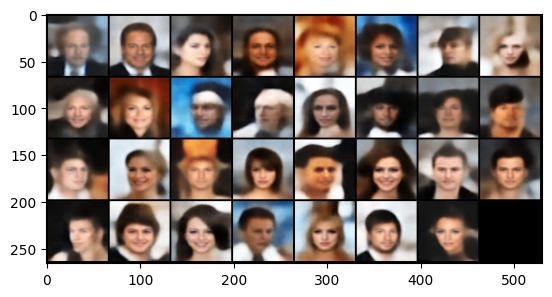

In [138]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
encoder = Encoder(latent_dim=128).to(device)
decoder = Decoder(latent_dim=128).to(device)
enc_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)
def loss_function(decoded_image,x):
    criterion = nn.MSELoss()
    loss = criterion(decoded_image[:,:,:,:], x[:,0:3,:,:])
    rmse = torch.sqrt(loss) 
    return rmse
num_epochs =5
for epoch in range(num_epochs):
    for i, (x,c,task2) in enumerate(train_loader):
        x = x.to(device)
        c = c.to(device)
        enc_optimizer.zero_grad()
        mean, z, encoded_image = encoder(x)
        # grid1 = vutils.make_grid(encoded_image, nrow=8, normalize=True, scale_each=True)
        # image1 = grid1.cpu().numpy().transpose((1, 2, 0))
        # plt.imshow(image1)
        # plt.show()
        zc_concat = torch.cat([z,c],dim =1) # z -> (batch_size,latent), c -> (batch_size,40)
        #zc ->(batch_size, latent+40)
        dec_optimizer.zero_grad()
        decoded_image = decoder(zc_concat)
        loss = loss_function(decoded_image, x)
        loss.backward()
        enc_optimizer.step()
        dec_optimizer.step()
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.10f}")
    torch.save(encoder.state_dict(), f"D:/sem2/adv_ML/HW3/saved_models/Trial2_fulldataset/encoder_celeba_{epoch+1}.pth")
    torch.save(decoder.state_dict(), f"D:/sem2/adv_ML/HW3/saved_models/Trial2_fulldataset/decoder_celeba_{epoch+1}.pth")
    grid2 = vutils.make_grid(decoded_image, nrow=8, normalize=True, scale_each=True)
    image2 = grid2.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(image2)
    plt.show()

**TASK 2**

In [139]:
encoder.load_state_dict(torch.load('D:/sem2/adv_ML/HW3/saved_models/Trial2_fulldataset/encoder_celeba_1.pth'))
decoder.load_state_dict(torch.load('D:/sem2/adv_ML/HW3/saved_models/Trial2_fulldataset/decoder_celeba_1.pth'))

<All keys matched successfully>

In [ ]:
import torchvision.utils as vutils
for i, (x,c,task2) in enumerate(test_loader):
        x = x.to(device)
        c = c.to(device)
        task2 = task2.to(device)
        mean, z, task2_encoded_image = encoder(x)
        ztask2_concat = torch.cat([z,task2],dim =1) #task2 gives the manipulated attribute --> this is changed in the preprocessing class
        task2_decoded_image = decoder(ztask2_concat)
        vutils.save_image(task2_decoded_image, f"D:/sem2/adv_ML/HW3/dayyapp_hw3/task2_images/full_imageset_trial/no_glasses_images_{i+1}.png", nrow=8)
        

**TASK 3**

In [15]:
encoder = Encoder(latent_dim=128).to(device)
decoder = Decoder(latent_dim=128).to(device)
encoder.load_state_dict(torch.load('D:/sem2/adv_ML/HW3/saved_models/Trial2_fulldataset/encoder_celeba_1.pth'))
decoder.load_state_dict(torch.load('D:/sem2/adv_ML/HW3/saved_models/Trial2_fulldataset/decoder_celeba_1.pth'))

<All keys matched successfully>

In [21]:
meanlist =[]
zlist =[]
clist = []
for i, (x,c,task2) in enumerate(test_loader):
    if i>2:
        break
    x = x.to(device)
    c = c.to(device)
    mean, z, task2_encoded_image = encoder(x)
    meanlist.append(mean)
    zlist.append(z)
    clist.append(c) 
    

In [22]:
batch1_mean = meanlist[0] #tensor having 32 image means  #size (32,latent) i.e (32,128)
batch2_mean = meanlist[1] #tensor having next 32 image means #size (32,latent) i.e (32,128)
batch1_z = zlist[0]
batch2_z = zlist[1]
batch1_c = clist[0]
batch2_c = clist[1]
#add_c = batch1_c+batch2_c

In [24]:
# Generate a series of images that morph from batch1 to batch2
num_steps = 10
for i in range(num_steps):
    # Compute the interpolation vector
    delta = i / (num_steps - 1)
    mu_interp = (1 - delta) * batch1_mean + delta * batch2_mean
    ztask3_concat = torch.cat([mu_interp,batch1_c],dim =1) #since moving from batch1 to batch2 images we choose the batch1 attribute vector
    #can choose batch2 attribute vector to move from batch2 to batch1
    # with torch.no_grad():
    img_interp = decoder(ztask3_concat)
    img_interp = (img_interp + 1) / 2.0  # Denormalize
    #img_interp = transforms.ToPILImage()(img_interp)  # Convert to PIL image
    vutils.save_image(img_interp, f"D:/sem2/adv_ML/HW3/dayyapp_hw3/task3_images/fulldataset_trained/transitioned_{i+1}.png", nrow=8)
    #img_interp.save(f'path/to/interpolated_{i}.jpg')